# INTRODUCTION

Will be going through AirBnB data for Seattle.


In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from decimal import Decimal
import datetime
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import *
import os
from IPython.display import HTML, display

Populating the interactive namespace from numpy and matplotlib


# DATA UNDERSTANDING

In [2]:
#Reading the Data from CSV using panda
calendar = pd.read_csv('calendar.csv')
listing = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

In [3]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [5]:
listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [6]:
listing['price'].values

array(['$85.00', '$150.00', '$975.00', ..., '$93.00', '$99.00', '$87.00'],
      dtype=object)

# DATA PREPARATION
Creating a function that removes '$' and percentage sing from the columns to work with.

In [7]:
# there is need to have a function that will remove '$' from currency columns

def remove_dollar_sign(data,column_name):
    column =  pd.to_numeric(data[column_name].apply(lambda x: str(x).replace('$', '').replace(',', '')), errors='coerce')
    return column

def remove_percentage_sign(data,column_name):
    column =  pd.to_numeric(data[column_name].apply(lambda x: str(x).replace('%', '').replace(',', '')), errors='coerce')
    return column

In [8]:
calendar = calendar.dropna(axis = 0, subset = ['price'], how = 'any')
reviews = reviews.dropna(axis = 0, subset = ['comments'], how = 'any')
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['month'] = calendar.date.dt.month
calendar['year'] = calendar.date.dt.year
calendar['day'] = calendar.date.dt.day
calendar['price'] = pd.to_numeric(calendar['price'].apply(lambda x: str(x).replace('$', '').replace(',', '')), errors='coerce')

listing['monthly_price'] = remove_dollar_sign(listing,'monthly_price')
listing['weekly_price'] = remove_dollar_sign(listing,'weekly_price')

listing['price'] = remove_dollar_sign(listing,'price')

listing['cleaning_fee'] = remove_dollar_sign(listing,'cleaning_fee')


listing['security_deposit'] = remove_dollar_sign(listing,'security_deposit')

listing['extra_people'] = remove_dollar_sign(listing,'extra_people')
listing = listing.rename(columns = {'id':'listing_id'})





# DATA REVIEW
Reviewing each of the data (listing, reviews and calendar), there seems to be some 'NaN' values in calendar and reviews while listing data seems to be more informative. I will take a deep dive into the listing data as it has more accurate information. Also, there is need to remove '$' sign from the price in order to have a floating column to work with.

In [9]:
listing.head()

,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


Reviewing the columns to know the percentage of missing values.

In [10]:
(listing.isnull().sum()[listing.isnull().sum().nonzero()[0]])/len(listing) 

summary                        0.046359
space                          0.149031
neighborhood_overview          0.270299
notes                          0.420639
transit                        0.244631
thumbnail_url                  0.083814
medium_url                     0.083814
xl_picture_url                 0.083814
host_name                      0.000524
host_since                     0.000524
host_location                  0.002095
host_about                     0.224987
host_response_time             0.136983
host_response_rate             0.136983
host_acceptance_rate           0.202462
host_is_superhost              0.000524
host_thumbnail_url             0.000524
host_picture_url               0.000524
host_neighbourhood             0.078575
host_listings_count            0.000524
host_total_listings_count      0.000524
host_has_profile_pic           0.000524
host_identity_verified         0.000524
neighbourhood                  0.108958
zipcode                        0.001833


The following columns will be neeeded for our insight.

property_type 
neighbourhood 
review_scores_value 
bathrooms 
bedrooms 
price 

In [11]:
default_list = listing[['property_type', 'neighbourhood', 'review_scores_value', 
                        'bathrooms', 'bedrooms', 'price','latitude','longitude']]

new_list = default_list.dropna(axis = 0, how = 'any')
new_list

,property_type,neighbourhood,review_scores_value,bathrooms,bedrooms,price,latitude,longitude
0,Apartment,Queen Anne,10.0,1.0,1.0,85.0,47.636289,-122.371025
1,Apartment,Queen Anne,10.0,1.0,1.0,150.0,47.639123,-122.365666
2,House,Queen Anne,10.0,4.5,5.0,975.0,47.629724,-122.369483
4,House,Queen Anne,9.0,2.0,3.0,450.0,47.632918,-122.372471
5,House,Queen Anne,10.0,1.0,1.0,120.0,47.630525,-122.366174
6,House,Queen Anne,10.0,1.0,1.0,80.0,47.636605,-122.368519
7,Cabin,Queen Anne,10.0,1.0,1.0,60.0,47.640161,-122.375856
8,Apartment,Queen Anne,10.0,1.0,1.0,90.0,47.632410,-122.357216
9,Apartment,Queen Anne,9.0,1.0,1.0,150.0,47.637492,-122.366889
10,House,Queen Anne,10.0,1.0,1.0,95.0,47.635482,-122.358478


Using seaborn to plot graph for our data.

In [12]:
# The function will be used to plot seaborn data.
def Plot(cur, data_list):
    plt.figure(figsize=(20,20))
    plt.xticks(rotation=90)
    sns.countplot((data_list)[(cur)],
                 order = data_list[cur].value_counts().index)
    plt.show()

In [13]:
(new_list.property_type.value_counts())/(new_list.property_type.count())

House              0.463732
Apartment          0.448592
Townhouse          0.025000
Condominium        0.022183
Loft               0.009859
Bed & Breakfast    0.008803
Cabin              0.007042
Other              0.004225
Camper/RV          0.002817
Bungalow           0.002817
Tent               0.001408
Boat               0.001408
Treehouse          0.000704
Dorm               0.000704
Yurt               0.000352
Chalet             0.000352
Name: property_type, dtype: float64

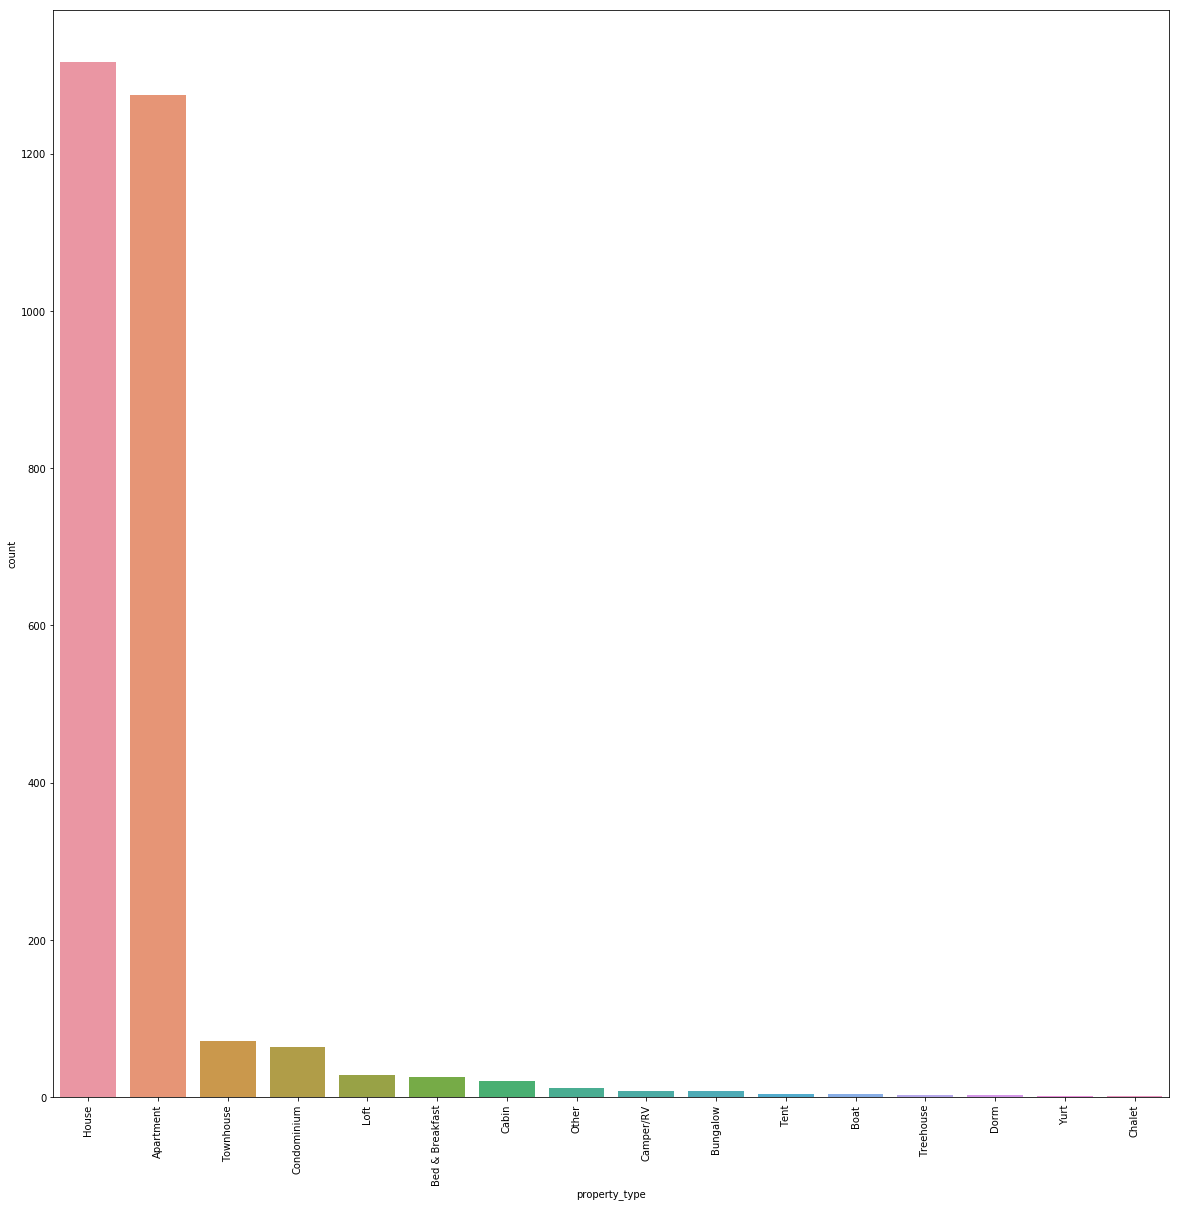

In [14]:
Plot('property_type', new_list)

In [15]:
(new_list.neighbourhood.value_counts())/(new_list.neighbourhood.count())

Capitol Hill                 0.099296
Ballard                      0.064437
Belltown                     0.062324
Minor                        0.061268
Queen Anne                   0.057042
Fremont                      0.044366
Wallingford                  0.044014
First Hill                   0.030986
North Beacon Hill            0.029225
University District          0.029225
Stevens                      0.026761
Central Business District    0.024296
Lower Queen Anne             0.022183
Greenwood                    0.020423
Columbia City                0.019014
Ravenna                      0.016549
Magnolia                     0.015493
North Admiral                0.015141
Phinney Ridge                0.015141
Atlantic                     0.015141
Green Lake                   0.014789
Leschi                       0.013732
Mount Baker                  0.013380
Eastlake                     0.012324
Maple Leaf                   0.011972
Madrona                      0.011620
Pike Place M

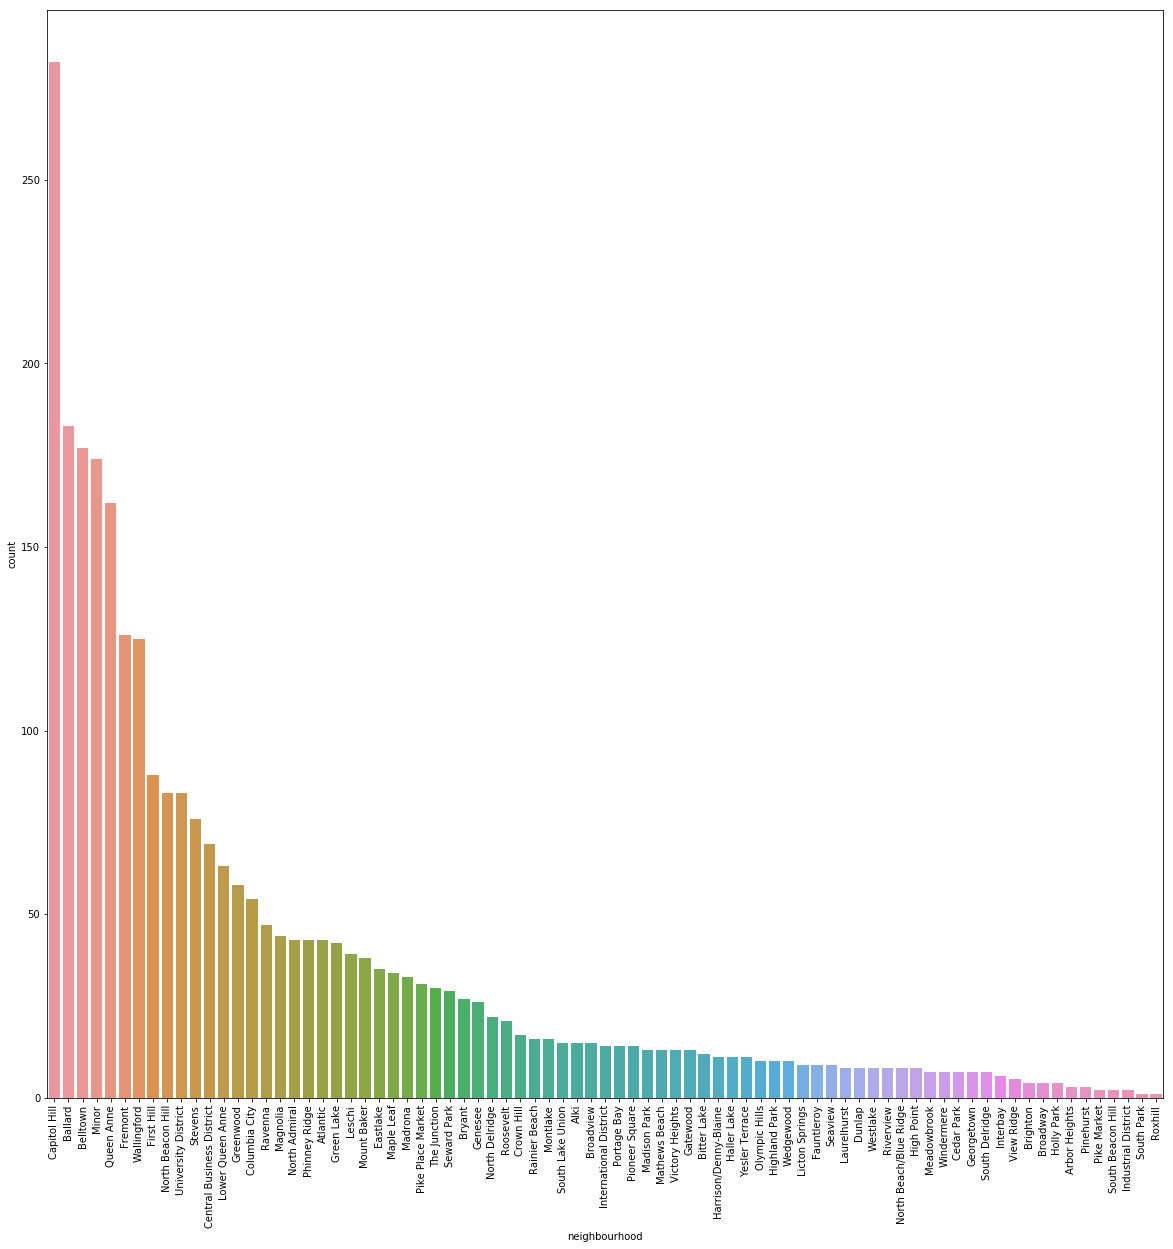

In [16]:
Plot('neighbourhood', new_list)

From the above graphs, i noticed that there are propert types that are in mostly listed in the dataset while some are fairly listed. Due to this, there is need to mini or limit the number of features to work with while maintaining data integrity. 

In [17]:
# Reducing the neighbourhood to TOP 27.
new_list_neighbourhood = new_list.groupby('neighbourhood').count()
new_list_top_15_neighbourhood = new_list_neighbourhood.nlargest(27,'property_type')
new_list_top_15_neighbourhood

,property_type,review_scores_value,bathrooms,bedrooms,price,latitude,longitude
neighbourhood,,,,,,,
Capitol Hill,282,282,282,282,282,282,282
Ballard,183,183,183,183,183,183,183
Belltown,177,177,177,177,177,177,177
Minor,174,174,174,174,174,174,174
Queen Anne,162,162,162,162,162,162,162
Fremont,126,126,126,126,126,126,126
Wallingford,125,125,125,125,125,125,125
First Hill,88,88,88,88,88,88,88
North Beacon Hill,83,83,83,83,83,83,83


In [18]:
# creating a list for the reduced neighbouhood.
neighbourhood_list = ['Capitol Hill',
'Ballard',
'Belltown',
'Minor',
'Queen Anne',
'Fremont',
'Wallingford',
'First Hill',
'North Beacon Hill',
'University District',
'Stevens',
'Central Business District',
'Lower Queen Anne',
'Greenwood',
'Columbia City',
'Ravenna',
'Magnolia',
'Atlantic',
'North Admiral',
'Phinney Ridge',
'Green Lake',
'Leschi',
'Mount Baker',
'Eastlake',
'Maple Leaf',
'Madrona',
'Pike Place Market']

Using the neighbourhood_list above, we filter out some of the data not needed.

In [19]:
#This gives me a list of True/False statements for each row if the value in the neighbourhood columns is in 
#neighbourhood_list above.
true_false_by_neighbourhood = new_list.neighbourhood.isin(neighbourhood_list) 

#I can then put this new list of True/False statements into our origional new_list. This filters new_list down
# to 37 categories of the neighbourhood column while reataining about 80% of the origional data.
filtered_neighborhood = new_list[true_false_by_neighbourhood]
filtered_neighborhood

,property_type,neighbourhood,review_scores_value,bathrooms,bedrooms,price,latitude,longitude
0,Apartment,Queen Anne,10.0,1.0,1.0,85.0,47.636289,-122.371025
1,Apartment,Queen Anne,10.0,1.0,1.0,150.0,47.639123,-122.365666
2,House,Queen Anne,10.0,4.5,5.0,975.0,47.629724,-122.369483
4,House,Queen Anne,9.0,2.0,3.0,450.0,47.632918,-122.372471
5,House,Queen Anne,10.0,1.0,1.0,120.0,47.630525,-122.366174
6,House,Queen Anne,10.0,1.0,1.0,80.0,47.636605,-122.368519
7,Cabin,Queen Anne,10.0,1.0,1.0,60.0,47.640161,-122.375856
8,Apartment,Queen Anne,10.0,1.0,1.0,90.0,47.632410,-122.357216
9,Apartment,Queen Anne,9.0,1.0,1.0,150.0,47.637492,-122.366889
10,House,Queen Anne,10.0,1.0,1.0,95.0,47.635482,-122.358478


In [20]:
#Applying the same for 'property_type'
new_list_property_type = new_list.groupby('property_type').count()
new_list_top_16_property_type = new_list_property_type.nlargest(16, 'neighbourhood')
new_list_top_16_property_type

,neighbourhood,review_scores_value,bathrooms,bedrooms,price,latitude,longitude
property_type,,,,,,,
House,1317,1317,1317,1317,1317,1317,1317
Apartment,1274,1274,1274,1274,1274,1274,1274
Townhouse,71,71,71,71,71,71,71
Condominium,63,63,63,63,63,63,63
Loft,28,28,28,28,28,28,28
Bed & Breakfast,25,25,25,25,25,25,25
Cabin,20,20,20,20,20,20,20
Other,12,12,12,12,12,12,12
Bungalow,8,8,8,8,8,8,8


In [21]:
# reducing the 'property_type' as represented by the top listed neighbourhoods.
property_type_list = ['House', 'Apartment', 'Townhouse', 'Condominium', 'Loft', 'Bed & Breakfast', 'Cabin']

In [22]:
#This gives me a list of True/False statements for each row if the value in the property_type column is in 
#the property_type_list above.
true_false_by_property = filtered_neighborhood.property_type.isin(property_type_list) 

#I can then put this new list of True/False statements into our filtered_neighbourhood list. 
#This filters new_list down seven property types while still containing 98.30% of the data of filtered_neighbourhood.
filtered_data = filtered_neighborhood[true_false_by_property]
filtered_data

,property_type,neighbourhood,review_scores_value,bathrooms,bedrooms,price,latitude,longitude
0,Apartment,Queen Anne,10.0,1.0,1.0,85.0,47.636289,-122.371025
1,Apartment,Queen Anne,10.0,1.0,1.0,150.0,47.639123,-122.365666
2,House,Queen Anne,10.0,4.5,5.0,975.0,47.629724,-122.369483
4,House,Queen Anne,9.0,2.0,3.0,450.0,47.632918,-122.372471
5,House,Queen Anne,10.0,1.0,1.0,120.0,47.630525,-122.366174
6,House,Queen Anne,10.0,1.0,1.0,80.0,47.636605,-122.368519
7,Cabin,Queen Anne,10.0,1.0,1.0,60.0,47.640161,-122.375856
8,Apartment,Queen Anne,10.0,1.0,1.0,90.0,47.632410,-122.357216
9,Apartment,Queen Anne,9.0,1.0,1.0,150.0,47.637492,-122.366889
10,House,Queen Anne,10.0,1.0,1.0,95.0,47.635482,-122.358478


In [23]:
# Filtering data base on property type.
def Filterlist(cur, data):
    """Description: This function can be used to read the file and filter based on the input.
    
    Arguments: 
    cur: the cursor object.
    data: data file
    
    Returns: 
    The data file that is filtered by the cur object."""
    
    property_type = [cur]
    true_false_by_property = filtered_data.property_type.isin(property_type) 
    List = filtered_data[true_false_by_property]
    return List

Measuring how expensive each neighbourhood is. The is based the seen correlation between prices and number of bedrooms.

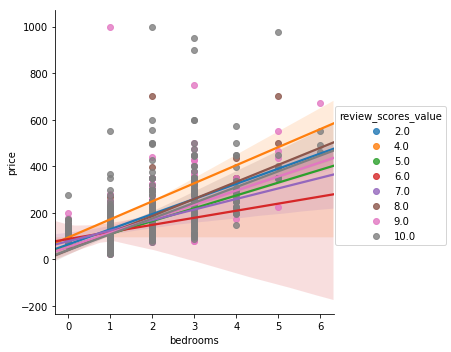

In [24]:
sns.lmplot(data=filtered_data, x='bedrooms', y='price', hue='review_scores_value')

The graphs shows that there is a correlation between number of rooms and prices. In other to dig deep, there is need to really get the average price per bedroom so that the possiblites of a neighbourhood becoming more expensive than the other base on higher number of rooms will be eliminated.

In [25]:
room_premium = (filtered_data.price)/(filtered_data.bedrooms)
filtered_data['Cost Per Bedroom'] = filtered_data['latitude'].add(room_premium)
filtered_data

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,property_type,neighbourhood,review_scores_value,bathrooms,bedrooms,price,latitude,longitude,Cost Per Bedroom
0,Apartment,Queen Anne,10.0,1.0,1.0,85.0,47.636289,-122.371025,132.636289
1,Apartment,Queen Anne,10.0,1.0,1.0,150.0,47.639123,-122.365666,197.639123
2,House,Queen Anne,10.0,4.5,5.0,975.0,47.629724,-122.369483,242.629724
4,House,Queen Anne,9.0,2.0,3.0,450.0,47.632918,-122.372471,197.632918
5,House,Queen Anne,10.0,1.0,1.0,120.0,47.630525,-122.366174,167.630525
6,House,Queen Anne,10.0,1.0,1.0,80.0,47.636605,-122.368519,127.636605
7,Cabin,Queen Anne,10.0,1.0,1.0,60.0,47.640161,-122.375856,107.640161
8,Apartment,Queen Anne,10.0,1.0,1.0,90.0,47.632410,-122.357216,137.632410
9,Apartment,Queen Anne,9.0,1.0,1.0,150.0,47.637492,-122.366889,197.637492
10,House,Queen Anne,10.0,1.0,1.0,95.0,47.635482,-122.358478,142.635482


In [26]:
# filtering data by house.
House_list = Filterlist('House', filtered_data)
House_list

,property_type,neighbourhood,review_scores_value,bathrooms,bedrooms,price,latitude,longitude,Cost Per Bedroom
2,House,Queen Anne,10.0,4.5,5.0,975.0,47.629724,-122.369483,242.629724
4,House,Queen Anne,9.0,2.0,3.0,450.0,47.632918,-122.372471,197.632918
5,House,Queen Anne,10.0,1.0,1.0,120.0,47.630525,-122.366174,167.630525
6,House,Queen Anne,10.0,1.0,1.0,80.0,47.636605,-122.368519,127.636605
10,House,Queen Anne,10.0,1.0,1.0,95.0,47.635482,-122.358478,142.635482
11,House,Queen Anne,9.0,1.0,1.0,99.0,47.637214,-122.360046,146.637214
13,House,Queen Anne,10.0,1.0,2.0,165.0,47.629507,-122.367629,130.129507
14,House,Queen Anne,10.0,3.5,6.0,461.0,47.639203,-122.365863,124.472536
17,House,Queen Anne,10.0,1.0,1.0,99.0,47.640646,-122.372406,146.640646
19,House,Queen Anne,8.0,3.5,5.0,700.0,47.636025,-122.358694,187.636025


# DATA MODELING
Let's get an insight on the data so far.

In [27]:
def catplot(x_data, y_data, data_list):
    """Description: This function can be used to read the file in the data_list and create a catplot based on the
    x_data and y_data.
    
    Arguments: 
    x_data: Column in data_list that you want to plot on the x axis (Put as string). 
    y_ data: Column in the data_list that you want to plot on the y axis (Put as string).
    data_list: The datalist that contains the x_data and y_data as columns."""
    #sns.catplot(x=x_data, y=y_data, data=data_list, height=8)
    plt.figure(figsize=(10, 8))
    sns.stripplot(x=x_data, y=y_data, data=data_list, size=5)

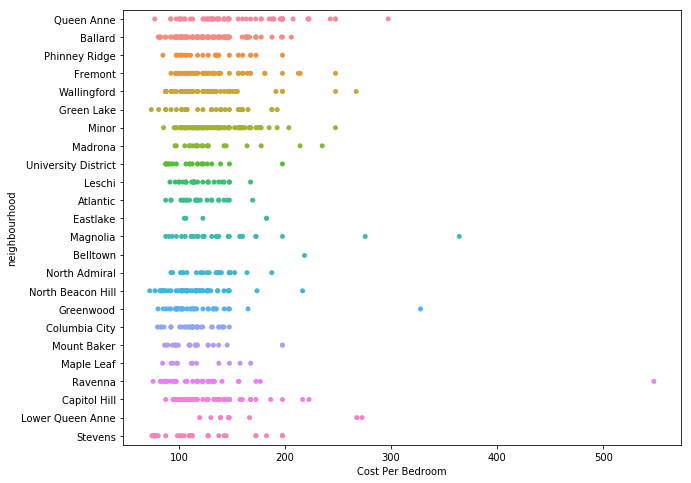

In [28]:
catplot('Cost Per Bedroom', 'neighbourhood', House_list)
#draw_histogram_data(House_list)

In [29]:
Apartment_list = Filterlist('Apartment', filtered_data)
Apartment_list

,property_type,neighbourhood,review_scores_value,bathrooms,bedrooms,price,latitude,longitude,Cost Per Bedroom
0,Apartment,Queen Anne,10.0,1.0,1.0,85.0,47.636289,-122.371025,132.636289
1,Apartment,Queen Anne,10.0,1.0,1.0,150.0,47.639123,-122.365666,197.639123
8,Apartment,Queen Anne,10.0,1.0,1.0,90.0,47.632410,-122.357216,137.632410
9,Apartment,Queen Anne,9.0,1.0,1.0,150.0,47.637492,-122.366889,197.637492
16,Apartment,Queen Anne,9.0,1.0,1.0,66.0,47.626200,-122.366602,113.626200
28,Apartment,Queen Anne,10.0,2.0,3.0,300.0,47.629907,-122.368948,147.629907
29,Apartment,Queen Anne,9.0,1.0,1.0,80.0,47.639816,-122.374338,127.639816
30,Apartment,Queen Anne,10.0,1.0,1.0,175.0,47.639008,-122.365320,222.639008
34,Apartment,Queen Anne,9.0,1.0,2.0,159.0,47.629816,-122.366212,127.129816
35,Apartment,Queen Anne,10.0,1.0,1.0,125.0,47.639810,-122.373801,172.639810


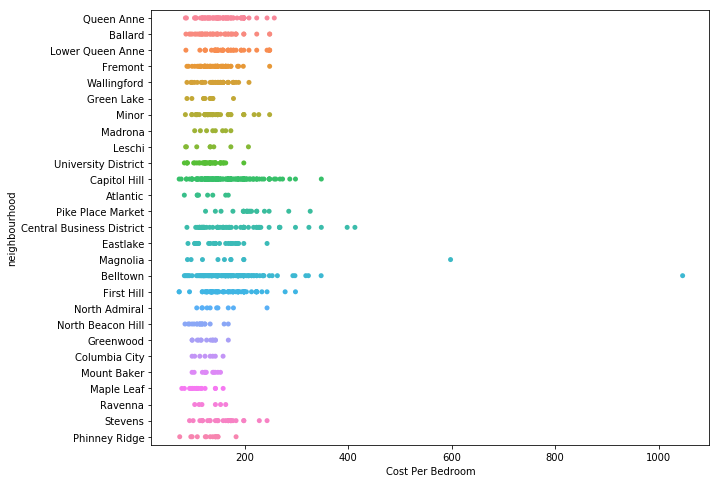

In [30]:
catplot('Cost Per Bedroom', 'neighbourhood', Apartment_list)

It seems that there is much more varability in terms of price for houses depending on the neighbourhood.

Queen Anne, Ballard, Minor, Capitol Hill, and Stevens looked among the most expensive neighbourhoods. However, that is debatable since the varability is so high.

For Apartments there is less varability in the price per room.

Queen Anne, Ballard, Lower Queen Anne, Minor, Capitol Hill, Pike Place Market, Central Business District, Belltown, and Firsthill ranked among the most expensive.


# PRIDICTING PRICE

In [31]:
df = listing[["host_response_rate", "host_acceptance_rate", "host_is_superhost",
               "host_listings_count", "zipcode", "property_type","room_type", "accommodates", "bathrooms", "bedrooms", 
               "beds", "price", "number_of_reviews", "review_scores_rating", "cancellation_policy", 
               "reviews_per_month"]]
df2=df.dropna(axis=0)

In [32]:
non_num_vars = df2.select_dtypes(include=['object']).columns
df2[non_num_vars].head()

,host_response_rate,host_acceptance_rate,host_is_superhost,zipcode,property_type,room_type,cancellation_policy
0,96%,100%,f,98119,Apartment,Entire home/apt,moderate
1,98%,100%,t,98119,Apartment,Entire home/apt,strict
2,67%,100%,f,98119,House,Entire home/apt,strict
6,100%,100%,t,98119,House,Private room,moderate
7,100%,100%,t,98119,Cabin,Private room,strict


In [33]:
#clean data to be used for predictions
pd.options.mode.chained_assignment = None  # default='warn'
df2['host_acceptance_rate'] = remove_percentage_sign(df2,'host_acceptance_rate')
df2['host_response_rate'] = remove_percentage_sign(df2,'host_response_rate')

In [34]:
df2['superhost']=np.where(df2['host_is_superhost']=='t',1,0)
del df2['host_is_superhost']

In [35]:
# select non-numeric variables and create dummies
non_num_vars = df2.select_dtypes(include=['object']).columns
df2[non_num_vars].head()

,zipcode,property_type,room_type,cancellation_policy
0,98119,Apartment,Entire home/apt,moderate
1,98119,Apartment,Entire home/apt,strict
2,98119,House,Entire home/apt,strict
6,98119,House,Private room,moderate
7,98119,Cabin,Private room,strict


In [36]:
dummy_vars = pd.get_dummies(df2[non_num_vars])
dummy_vars.head()

,zipcode_98101,zipcode_98102,zipcode_98103,zipcode_98104,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,...,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [37]:
# drop non-numeric variables from df2 and add the dummies
df3=df2.drop(non_num_vars,axis=1)
df3 = pd.merge(df3,dummy_vars, left_index=True, right_index=True)
df3.head()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,...,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,96,100,3.0,4,1.0,1.0,1.0,85.0,207,95.0,...,0,0,0,0,1,0,0,0,1,0
1,98,100,6.0,4,1.0,1.0,1.0,150.0,43,96.0,...,0,0,0,0,1,0,0,0,0,1
2,67,100,2.0,11,4.5,5.0,7.0,975.0,20,97.0,...,0,0,0,0,1,0,0,0,0,1
6,100,100,1.0,2,1.0,1.0,1.0,80.0,58,99.0,...,0,0,0,0,0,1,0,0,1,0
7,100,100,5.0,2,1.0,1.0,1.0,60.0,173,97.0,...,0,0,0,0,0,1,0,0,0,1


Text(0.5,1,'Histogram of listing prices')

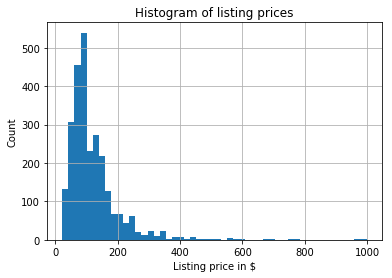

In [38]:
# Some summary stats
df3['price'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Listing price in $')
plt.title('Histogram of listing prices')

In [39]:
cols = ['number_of_reviews','host_acceptance_rate','host_listings_count','accommodates',
       'bathrooms','bedrooms','beds','price']

# Visualizing correlations through heatmap

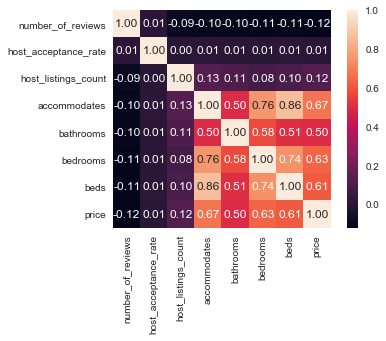

In [40]:
# heatmap
corrs = np.corrcoef(df3[cols].values.T)
sns.set(font_scale=1)
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols)

# Prediction Examples

In [41]:
# split into test and training data
np.random.seed(1)
indices = np.random.permutation(len(df3))
train_size = int(round(0.8*len(df3)))
test_size = len(df3)-train_size

y = df3['price']
x = df3.drop('price', axis =1)

x.train = x.iloc[indices[0:train_size]]
y.train = y.iloc[indices[0:train_size]]
x.test = x.iloc[indices[train_size+1:]]
y.test = y.iloc[indices[train_size+1:]]

x2 = x.train.as_matrix()
y2 = y.train.as_matrix()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # Remove the CWD from sys.path while we load stuff.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Metho

In [42]:
#Applying statistical model on training model.

olsmod = sm.OLS(y2,x2)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     73.20
Date:                Thu, 28 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:22:46   Log-Likelihood:                -11196.
No. Observations:                2125   AIC:                         2.251e+04
Df Residuals:                    2067   BIC:                         2.284e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1913      0.100     -1.922      0.0

In [43]:
x0 = x.test.as_matrix()
y0 = y.test.as_matrix()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [44]:
ypred = olsres.predict(x0) # out of sample prediction
rms_ols = sqrt(mean_squared_error(y0,ypred))

In [45]:
rms_ols

56.38292278388188

In [46]:
# plot predictions agains true values as function of bedrooms
beds = x.test['bedrooms'].as_matrix()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


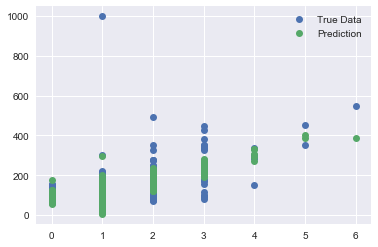

In [47]:
fig, ax = plt.subplots()
ax.plot(beds,y0, 'o', label = 'True Data')
ax.plot(beds, ypred, 'o', label = 'Prediction')
ax.legend(loc = 'best')

In [48]:
# different method

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
slr = linear_model.LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

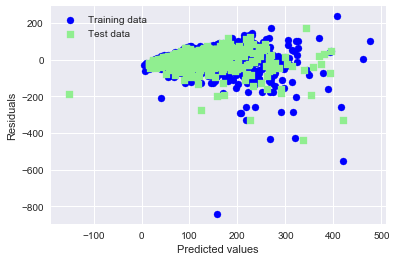

In [49]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()

In [50]:

rms_ols2=sqrt(mean_squared_error(y_test,y_test_pred))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 2531.745, test: 2357.700
R^2 train: 0.613, test: 0.658


# Random forest

In [51]:

forest = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 360.229, test: 2275.514
R^2 train: 0.945, test: 0.670


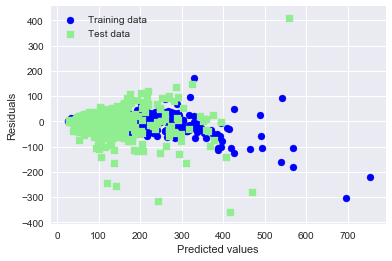

In [52]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()

In [53]:
rmse_randfor=sqrt(mean_squared_error(y_test,y_test_pred))

In [54]:
compare = pd.Series( [rms_ols, rms_ols2, rmse_randfor], index = ["ols1","ols2","random forest"])
compare

ols1             56.382923
ols2             48.556154
random forest    47.702347
dtype: float64